Copyright (c) 2020. Cognitive Scale Inc. All rights reserved.
Licensed under CognitiveScale Example Code [License](https://github.com/CognitiveScale/cortex-certifai-examples/blob/master/LICENSE.md)


# Analyzing Feature Usage

In this notebook we'll use Certifai to generate counterfactual explanations of two models' predictions for a given
dataset.  By construction these will be data points optimized to be close to the model's decision boundary under
a normalizing constraint of sparsity in changed features over the corresponding original data points.

We will then analyze these counterfactual differences to obtain a frequency of occurrence of each feature in them,
which is plotted as a histogram for each of two comparative models built on the same dataset.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
import random
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from certifai.scanner.builder import (CertifaiScanBuilder, CertifaiPredictorWrapper, CertifaiModel, CertifaiModelMetric,
                                      CertifaiDataset, CertifaiGroupingFeature, CertifaiDatasetSource,
                                      CertifaiPredictionTask, CertifaiTaskOutcomes, CertifaiOutcomeValue,
                                      CertifaiFeatureRestriction)
from certifai.common.utils.encoding import CatEncoder
from certifai.scanner.explanation_utils import (construct_explanations_dataframe, explanations, 
                                                counterfactual_feature_frequency)

In [2]:
# Example will use a simple logistic classifier on the German Credit dataset
base_path = '..'
all_data_file = f"{base_path}/datasets/german_credit_eval.csv"

df = pd.read_csv(all_data_file)

cat_columns = [
    'checkingstatus',
    'history',
    'purpose',
    'savings',
    'employ',
    'status',
    'others',
    'property',
    'age',
    'otherplans',
    'housing',
    'job',
    'telephone',
    'foreign'
    ]

label_column = 'outcome'

# Separate outcome
y = df[label_column]
X = df.drop(label_column, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Note - to support python multi-processing in the context of a notebook the encoder MUST
# be in a separate file, which is why `CatEncoder` is defined outside of this notebook
encoder = CatEncoder(cat_columns, X)

# Fit a classification models (note - no train/test split here currently as I'm just using the same data as
# the scan will)
logistic_model = LogisticRegression(random_state=0, solver="lbfgs", max_iter=1000)
logistic_model.fit(encoder(X_train.values), y_train.values)
dtree_model = DecisionTreeClassifier()
dtree_model.fit(encoder(X_train.values), y_train.values)

# Assess on the test set
logistic_accuracy = logistic_model.score(encoder(X_test.values), y_test.values)
print(f"Logistic classifier model accuracy on test data is {logistic_accuracy}")
dtree_accuracy = dtree_model.score(encoder(X_test.values), y_test.values)
print(f"Decision tree model accuracy on test data is {dtree_accuracy}")

Logistic classifier model accuracy on test data is 0.77
Decision tree model accuracy on test data is 0.725


In [3]:
# Wrap the model up for use by Certifai as a local model
logistic_model_proxy = CertifaiPredictorWrapper(logistic_model, encoder=encoder)
dtree_model_proxy = CertifaiPredictorWrapper(dtree_model, encoder=encoder)

In [4]:
# Create a scan to extract counterfactual explanations of the model predictions and build
# a histogram of the feature usage in those counterfactuals

# First define the possible prediction outcomes
task = CertifaiPredictionTask(CertifaiTaskOutcomes.classification(
    [
        CertifaiOutcomeValue(1, name='Loan granted', favorable=True),
        CertifaiOutcomeValue(2, name='Loan denied')
    ]),
    prediction_description='Determine whether a loan should be granted')

scan = CertifaiScanBuilder.create('test_use_case',
                                  prediction_task=task)
# Add our local models
first_model = CertifaiModel('logistic',
                            local_predictor=logistic_model_proxy)
scan.add_model(first_model)
second_model = CertifaiModel('dtree',
                            local_predictor=dtree_model_proxy)
scan.add_model(second_model)

# Add the eval dataset
eval_dataset = CertifaiDataset('evaluation',
                               CertifaiDatasetSource.csv(all_data_file))
scan.add_dataset(eval_dataset)

# don't allow changes to the nationality status
scan.add_feature_restriction('foreign', CertifaiFeatureRestriction.constant())

# Setup an evaluation for explanation on the above dataset using the model
scan.add_evaluation_type('explanation')
scan.evaluation_dataset_id = 'evaluation'
# For this analysis we'll generate explanations for the entire dataset so we have a good number
# on which to base statistical measures
scan.explanation_dataset_id = 'evaluation'

# Because the dataset contains a ground truth outcome column which the model does not
# expect to receive as input we need to state that in the dataset schema (since it cannot
# be inferred from the CSV)
scan.dataset_schema.outcome_feature_name = 'outcome'

# Run the scan.
# By default this will write the results into individual report files (one per model and evaluation
# type) in the 'reports' directory relative to the Jupyter root.  This may be disabled by specifying
# `write_reports=False` as below
# The result is a dictionary of dictionaries of reports.  The top level dict key is the evaluation type
# and the second level key is model id.
# Reports saved as JSON (which `write_reports=True` will do) may be visualized in the console app
results = scan.run(write_reports=False)


Starting scan with model_use_case_id: 'test_use_case' and scan_id: '6daa192a5f47'
[--------------------] 2020-10-23 16:13:08.409022 - 0 of 2 reports (0.0% complete) - Running explanation evaluation for model: logistic
[##########----------] 2020-10-23 16:18:00.340960 - 1 of 2 reports (50.0% complete) - Running explanation evaluation for model: dtree
[####################] 2020-10-23 16:21:00.572205 - 2 of 2 reports (100.0% complete) - Completed all evaluations


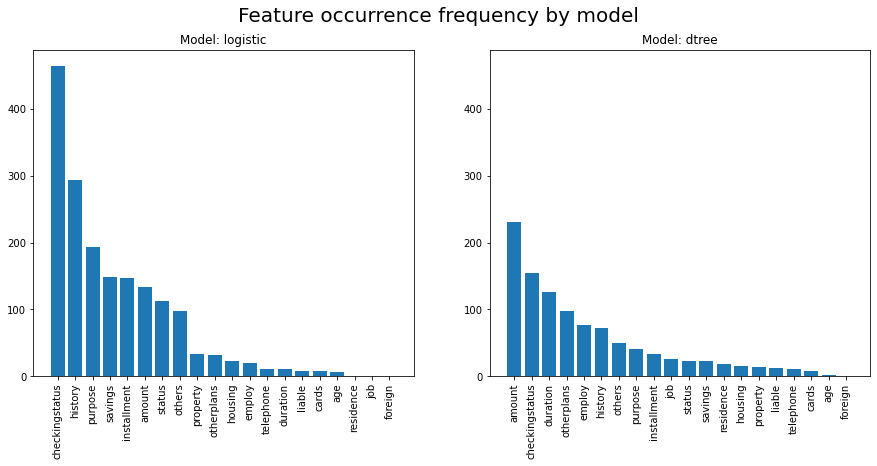

In [7]:
# Plot a histogram of frequency of occurrence of changes to each feature in counterfactuals
%matplotlib inline
import matplotlib.pyplot as plt

def plot_histogram(ax, model_id):
    model_shap_df = construct_explanations_dataframe(explanations(results, model_id=model_id))
    changes = counterfactual_feature_frequency(model_shap_df)
    sorted_changes = changes.sort_values(ascending=False)
    indexes = np.arange(len(sorted_changes))
    ax.bar(indexes,sorted_changes.values)

    ax.ylabel = 'Frequency'
    ax.set_title(f'Model: {model_id}')
    ax.set_xticks(indexes)
    ax.set_xticklabels(sorted_changes.index, rotation=90)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15,6])
fig.suptitle('Feature occurrence frequency by model', fontsize=20)

plot_histogram(ax1, 'logistic')
plot_histogram(ax2, 'dtree')

# Put them both on the same scale
ylim = max(ax1.get_ylim()[1], ax2.get_ylim()[1])
ax1.set_ylim(top=ylim)
ax2.set_ylim(top=ylim)

plt.show()